In [ ]:
!pip install wget

# Overfitting and Cross-Validation

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams["font.size"] = 20
mpl.rcParams["lines.linewidth"] = 2

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


def seed_all(seed):
    random.seed(seed)
    np.random.seed(seed)

# for the purpose of reproduce
SEED = 0
seed_all(SEED)

## Load Dataset

In [ ]:
!python -m wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv \
    --output delaney-processed.csv

In [4]:
DELANEY_FILE = "delaney-processed.csv"
TASK_COL = 'measured log solubility in mols per litre'
df = pd.read_csv(DELANEY_FILE)
print(f"Number of molecules in the dataset: {df.shape[0]}")

Number of molecules in the dataset: 1128


## Polynomial Fitting

In [5]:
X = df["Molecular Weight"].values
y = df[TASK_COL].values

In [6]:
# do 90:10 train:test split
test_size = int(len(X)*0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

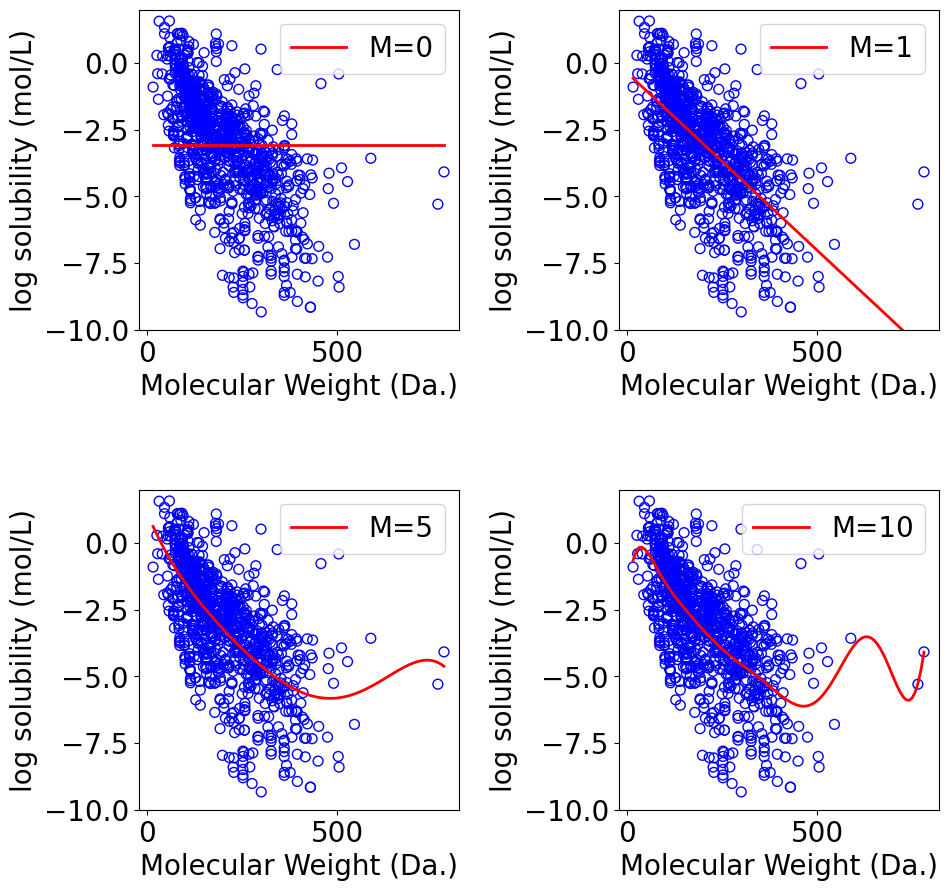

In [7]:
orders = [0, 1, 5, 10]
mse_train_list = []

ncols = 2
nrows = len(orders)//ncols if len(orders)%ncols==0 else len(orders)//ncols+1
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
axs = axs.flatten()
fig.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=0.5)

for idx, M in enumerate(orders):
    # use numpy polynomial fitting
    # Use klearn PolynomialFeature+LinearRegression will not cause dramatic overfitting when M=subsamples-1
    p = np.poly1d(np.polyfit(X_train.reshape(-1), y_train.reshape(-1), M))

    y_train_pred = p(X_train)
    mse_train = np.mean((y_train_pred-y_train)**2)
    mse_train_list.append(mse_train)

    # plot sampled datapoints
    ax = axs[idx]
    ax.scatter(X_train, y_train,
                s=50, marker='o', facecolors='none', edgecolor="blue")

    # plot fitting curve
    x_lin = np.linspace(np.min(X), np.max(X), 100).reshape(-1, 1)
    ax.plot(x_lin, p(x_lin), "red", label=f"M={M}")
    ax.set_ylim(-10, 2)
    ax.set_xlabel("Molecular Weight (Da.)")
    ax.set_ylabel("log solubility (mol/L)")
    ax.legend(loc="upper right")

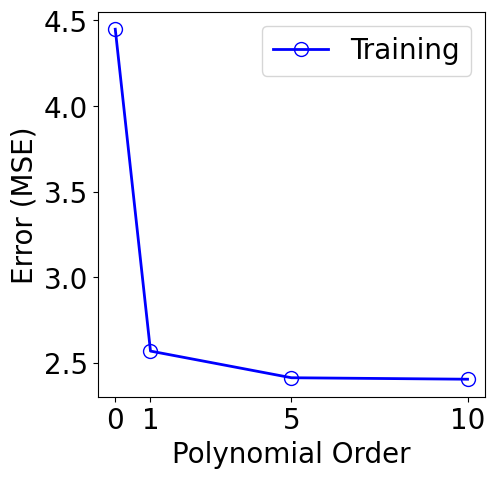

In [8]:
plt.figure(figsize=(5, 5))
plt.plot(orders, mse_train_list, "-", color="b",
         marker="o", markersize=10, markerfacecolor="none", markeredgecolor="b", label="Training")
plt.xlabel("Polynomial Order")
plt.ylabel("Error (MSE)")
plt.xticks(orders)
plt.legend()

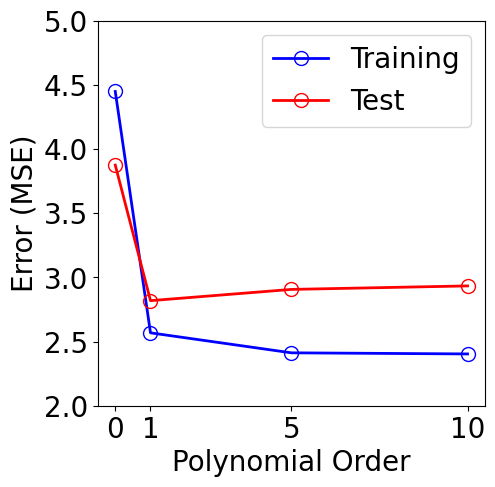

In [9]:
## scanning
mse_train_list = []
mse_test_list = []

for M in orders:
    p = np.poly1d(np.polyfit(X_train, y_train, M))


    # predict and calculate rmse of training dataset
    y_train_pred = p(X_train)
    mse_train = np.mean((y_train_pred-y_train)**2)
    mse_train_list.append(mse_train)

    # predict and calculate rmse of test dataset
    y_test_pred = p(X_test)
    mse_test = np.mean((y_test_pred-y_test)**2)
    mse_test_list.append(mse_test)

plt.figure(figsize=(5, 5))
plt.plot(orders, mse_train_list, "-", color="b",
         marker="o", markersize=10, markerfacecolor="none", markeredgecolor="b", label="Training")
plt.plot(orders, mse_test_list, "-", color="r",
         marker="o", markersize=10, markerfacecolor="none", markeredgecolor="r", label="Test")
plt.xlabel("Polynomial Order")
plt.ylabel("Error (MSE)")
plt.ylim([2, 5])
plt.xticks(orders)
plt.legend()

## Cross Validation

In [10]:
def run_one_fold(X_train, y_train, X_test, y_test, M):
    p = np.poly1d(np.polyfit(X_train, y_train, M))
    # predict and calculate rmse of training dataset
    y_train_pred = p(X_train)
    mse_train = np.mean((y_train_pred-y_train)**2)

    # predict and calculate rmse of test dataset
    y_test_pred = p(X_test)
    mse_test = np.mean((y_test_pred-y_test)**2)
    return mse_train, mse_test

In [11]:
## 10-fold
n_splits = 10

mse_train_list = []
std_train_list = []
mse_test_list = []
std_test_list = []

cv_df = pd.DataFrame(columns=["M", "MSE_train", "MSE_test"])

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for M in orders:
    mse_train_fold = []
    mse_test_fold = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        mse_train, mse_test = run_one_fold(X_train, y_train, X_test, y_test, M)
        mse_train_fold.append(mse_train)
        mse_test_fold.append(mse_test)

    mse_train_list.append(np.mean(mse_train_fold))
    std_train_list.append(np.std(mse_train_fold))
    mse_test_list.append(np.mean(mse_test_fold))
    std_test_list.append(np.std(mse_test_fold))


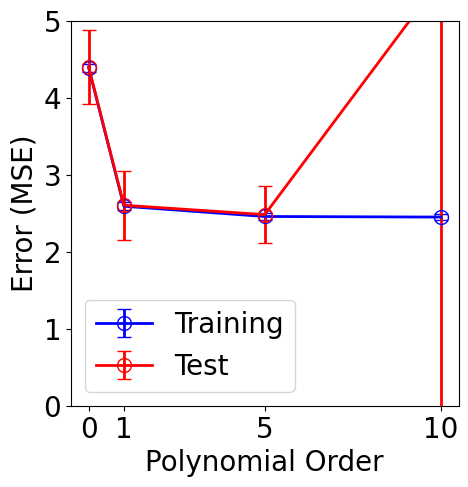

In [12]:
plt.figure(figsize=(5, 5))
plt.errorbar(orders, mse_train_list, yerr=std_train_list, color="b", \
    marker="o", markersize=10, markerfacecolor="none", markeredgecolor="b",
    capsize=5, label="Training")
plt.errorbar(orders, mse_test_list, yerr=std_test_list, color="r", \
    marker="o", markersize=10, markerfacecolor="none", markeredgecolor="r",
    capsize=5, label="Test")
plt.xlabel("Polynomial Order")
plt.ylabel("Error (MSE)")
plt.xticks(orders)
plt.ylim([0, 5])
plt.legend()